In [1]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
import napari
from skimage import io
import random
import h5py
from skimage import measure
from brainlit.preprocessing import removeSmallCCs
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import tables
from napari_animation import AnimationWidget
from tqdm import tqdm
import pickle
from parse_ara import *
import networkx as nx
import seaborn as sns
from statannotations.Annotator import Annotator
import pandas as pd
import brainrender
import scipy.ndimage as ndi
from skimage.morphology import skeletonize
from axon_data import brain2paths as brain2paths_axon
from util import find_sample_names
from soma_data import brain2paths as brain2paths_soma
import os
from util import json_to_points
import scipy.ndimage as ndi
import random
from cloudvolume import CloudVolume

%gui qt5

# Axon

## Intensity Histograms

In [2]:
data = {
    "8649": ([2192, 1244, 1332], [901, 2559, 1332]),
    "8650": ([2378, 948, 1851], [2302, 5705, 1851]),
    "8589": ([4312, 4163, 1450], [1335, 6119, 1450]),
    "8613": ([3911, 3461, 1514], [1411, 5720, 1514]),
    "8590": ([1394, 1940, 1854], [4776, 816, 1854]),
}  # axon center then nonaxon center

data2 = {}
for i in ["8650", "8589", "8590"]:
    data2[i] = data[i]
data = data2

intensities = []
brain_ids = []
vol_type = []
# viewer = napari.Viewer(ndisplay=2)


for i, brain in enumerate(data.keys()):
    vol = CloudVolume(brain2paths_axon[brain]["base"] + "Ch_647")
    coord = data[brain][0]
    subvol = vol[
        coord[0] - 9 : coord[0] + 10,
        coord[1] - 9 : coord[1] + 10,
        coord[2] - 9 : coord[2] + 10,
    ]
    # viewer.add_image(np.squeeze(subvol), name=f"{brain} axon", scale = [1.83, 1.83, 2])
    num_entries = len(subvol.flatten())
    intensities += list(subvol.flatten())
    brain_ids += [i] * num_entries
    vol_type += [f"Axon"] * num_entries

    coord = data[brain][1]
    subvol = vol[
        coord[0] - 9 : coord[0] + 10,
        coord[1] - 9 : coord[1] + 10,
        coord[2] - 9 : coord[2] + 10,
    ]
    # viewer.add_image(np.squeeze(subvol), name=f"{brain} bg", scale = [1.83, 1.83, 2])
    num_entries = len(subvol.flatten())
    intensities += list(subvol.flatten())
    brain_ids += [i] * num_entries
    vol_type += [f"Background"] * num_entries

# # viewer.camera.angles = [45, 45, 45]
# viewer.scale_bar.visible = True
# viewer.scale_bar.unit = "um"
df = pd.DataFrame(
    data={"Intensity": intensities, "Subvolume Type": vol_type, "Sample": brain_ids}
)

Downloading: 100%|██████████| 19/19 [00:03<00:00,  5.01it/s]


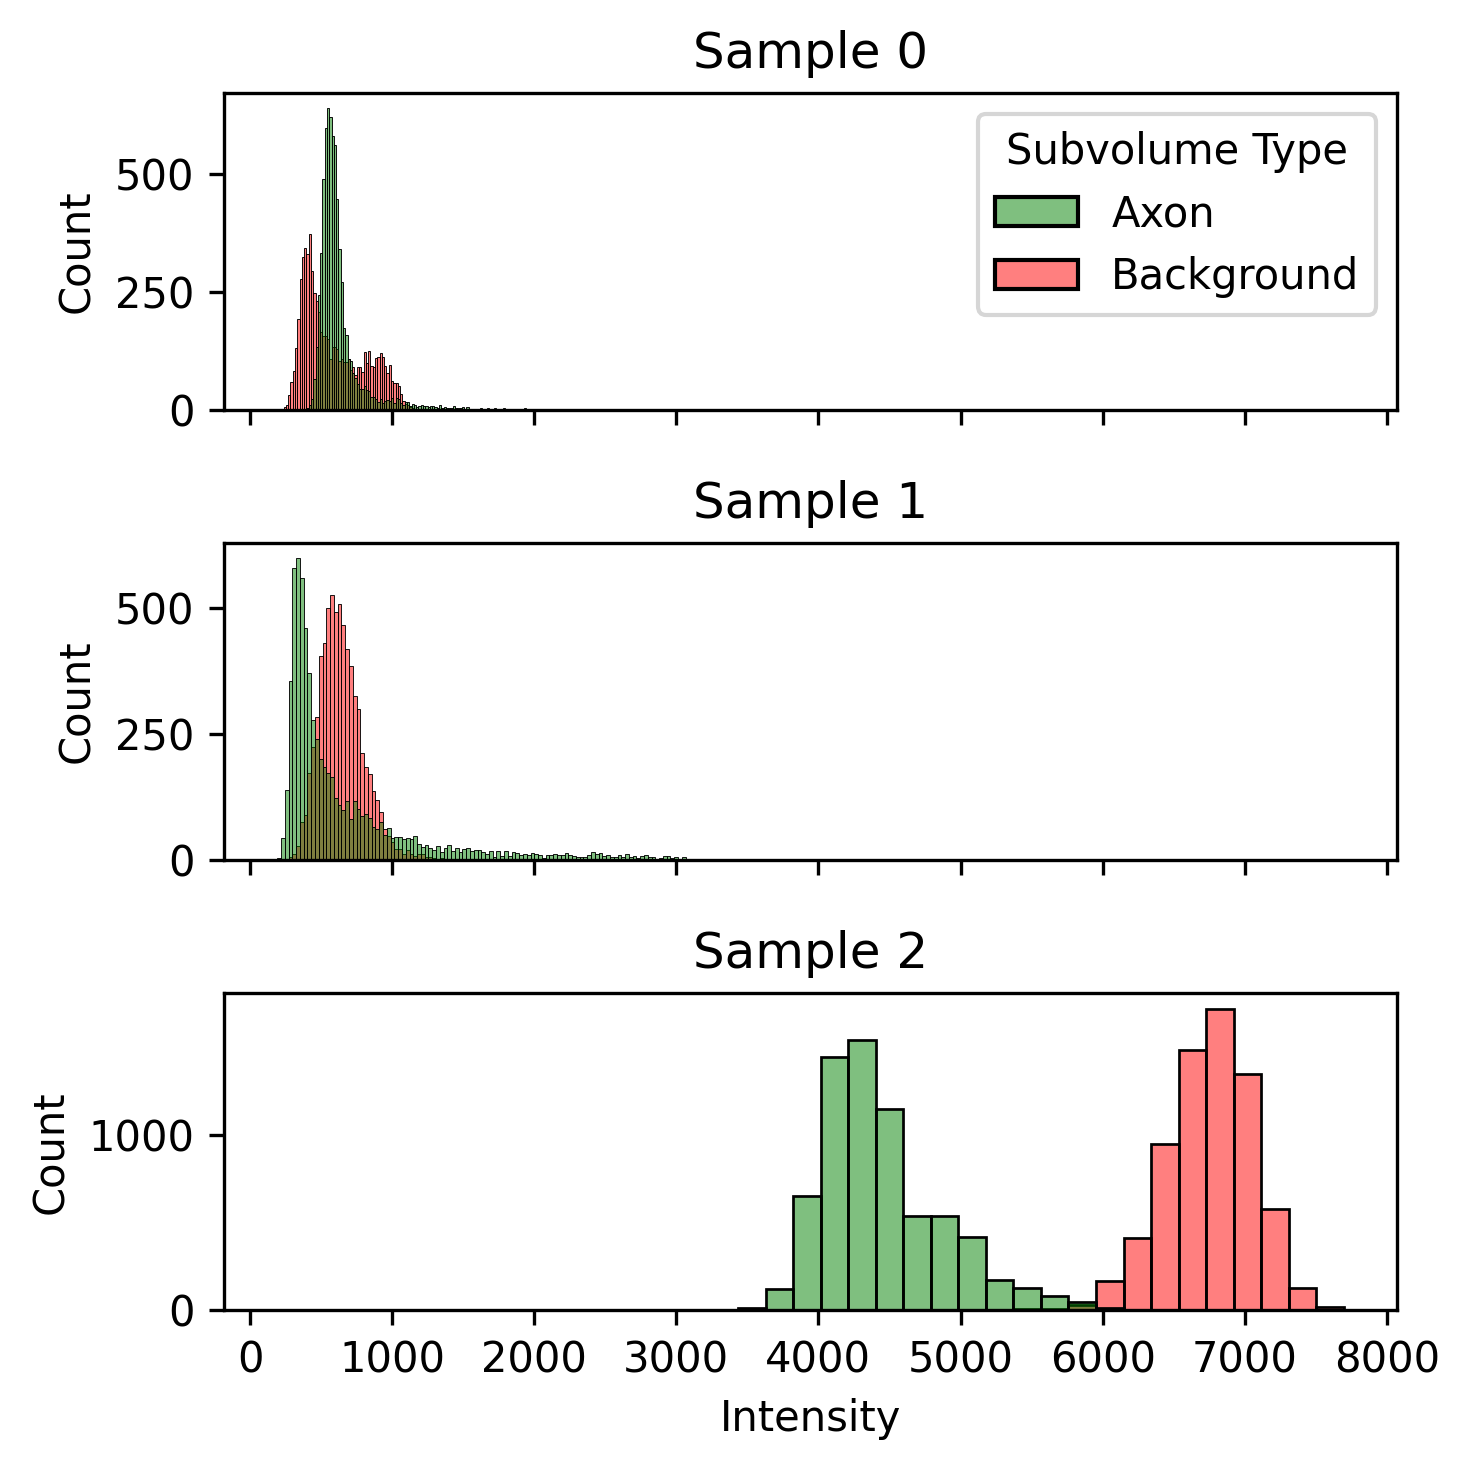

In [3]:
fig, axs = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(5, 5))
for i in range(3):
    hist = sns.histplot(
        data=df[df["Sample"] == i],
        x="Intensity",
        hue="Subvolume Type",
        ax=axs[i],
        palette=["green", "red"],
    )
    axs[i].set_title(f"Sample {i}")
    if i > 0:
        hist.get_legend().remove()
plt.tight_layout()

## Compare to sample number

In [4]:
# training set results
training_brain_order = [3, 4, 8649, 8788]
models_diff = []
models_same = []

for i, brain in enumerate(training_brain_order):
    model_diff = "-compare"
    for j, brain2 in enumerate(training_brain_order[: i + 1]):
        model_diff += "-"
        model_diff += str(brain2)

        model_same = "-compare-3"
        if j > 0:
            model_same += f"_{j+1}"

    models_diff.append(model_diff)
    models_same.append(model_same)

print(f"heterogeneous: {models_diff} homogeneous: {models_same}")

heterogeneous: ['-compare-3', '-compare-3-4', '-compare-3-4-8649', '-compare-3-4-8649-8788'] homogeneous: ['-compare-3', '-compare-3_2', '-compare-3_3', '-compare-3_4']


In [5]:
brain_order = [8650, 8649, 8613, 8589, 8590, 8788, 8786, 8790, 11537]
training_set_sizes = [10, 20, 25, 30]
train_sizes = []
model_lines = []
fscores = []
brains = []

for brain in tqdm(brain_order, desc="Evaluating brains..."):
    brain_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain{brain}/"
    # identify images an split into val and test
    files = find_sample_names(brain_dir, dset="val", add_dir=False)
    random.shuffle(files)
    half = int(len(files) / 2)
    val_files = files[:half]
    test_files = files[half:]

    for model_line, models in zip(
        ["Heterogeneous", "Homogeneous"], [models_diff, models_same]
    ):
        for model, train_size in zip(models, training_set_sizes):
            results_dir = brain_dir + "results" + model

            # val - choose best threshold
            true_files = []
            pred_files = []
            for val_file in val_files:
                true_file = (
                    f"{brain_dir}/{val_file.split('.')[0]}-image_2channel_Labels.h5"
                )
                true_files.append(true_file)
                pred_file = f"{results_dir}/{val_file.split('.')[0]}_Probabilities.h5"
                pred_files.append(pred_file)

            spacing = 0.02
            thresholds = np.arange(spacing, 1.0, spacing)
            best_fscore = 0
            best_thresh = -1

            for threshold in thresholds:
                true_pos_total = 0
                false_pos_total = 0
                true_labels_total = 0

                for true_file, pred_file in zip(true_files, pred_files):
                    f = h5py.File(pred_file, "r")
                    seg = f.get("exported_data")
                    seg = seg[1, :, :, :]
                    mask_forward = seg > threshold

                    f = h5py.File(true_file, "r")
                    gt = f.get("exported_data")
                    gt = gt[0, :, :, :]
                    pos_labels = gt == 2
                    neg_labels = gt == 1

                    true_pos = np.sum(np.logical_and(mask_forward, pos_labels))
                    true_pos_total += true_pos

                    false_pos = np.sum(np.logical_and(mask_forward, gt == 1))
                    false_pos_total += false_pos

                    true_labels = np.sum(pos_labels)
                    true_labels_total += true_labels

                precision_total = true_pos_total / (true_pos_total + false_pos_total)
                recall_total = true_pos_total / true_labels_total
                fscore = 2 / (1 / precision_total + 1 / recall_total)

                if fscore > best_fscore:
                    best_fscore = fscore
                    best_thresh = threshold

            # test
            true_files = []
            pred_files = []
            for val_file in test_files:
                true_file = (
                    f"{brain_dir}/{val_file.split('.')[0]}-image_2channel_Labels.h5"
                )
                true_files.append(true_file)
                pred_file = f"{results_dir}/{val_file.split('.')[0]}_Probabilities.h5"
                pred_files.append(pred_file)

            true_pos_total = 0
            false_pos_total = 0
            true_labels_total = 0

            for true_file, pred_file in zip(true_files, pred_files):
                f = h5py.File(pred_file, "r")
                seg = f.get("exported_data")
                seg = seg[1, :, :, :]
                mask_forward = seg > best_thresh

                f = h5py.File(true_file, "r")
                gt = f.get("exported_data")
                gt = gt[0, :, :, :]
                pos_labels = gt == 2
                neg_labels = gt == 1

                true_pos = np.sum(np.logical_and(mask_forward, pos_labels))
                true_pos_total += true_pos

                false_pos = np.sum(np.logical_and(mask_forward, gt == 1))
                false_pos_total += false_pos

                true_labels = np.sum(pos_labels)
                true_labels_total += true_labels

            precision_total = true_pos_total / (true_pos_total + false_pos_total)
            recall_total = true_pos_total / true_labels_total
            fscore = 2 / (1 / precision_total + 1 / recall_total)

            fscores.append(fscore)
            train_sizes.append(train_size)
            brains.append(brain)

            model_lines.append(model_line)

Evaluating brains...: 100%|██████████| 9/9 [03:05<00:00, 20.62s/it]


[
    <matplotlib.axis.XTick object at 0x15f9963a0>,
    <matplotlib.axis.XTick object at 0x15f996370>,
    <matplotlib.axis.XTick object at 0x15f9a5b80>,
    <matplotlib.axis.XTick object at 0x15fa12160>
]

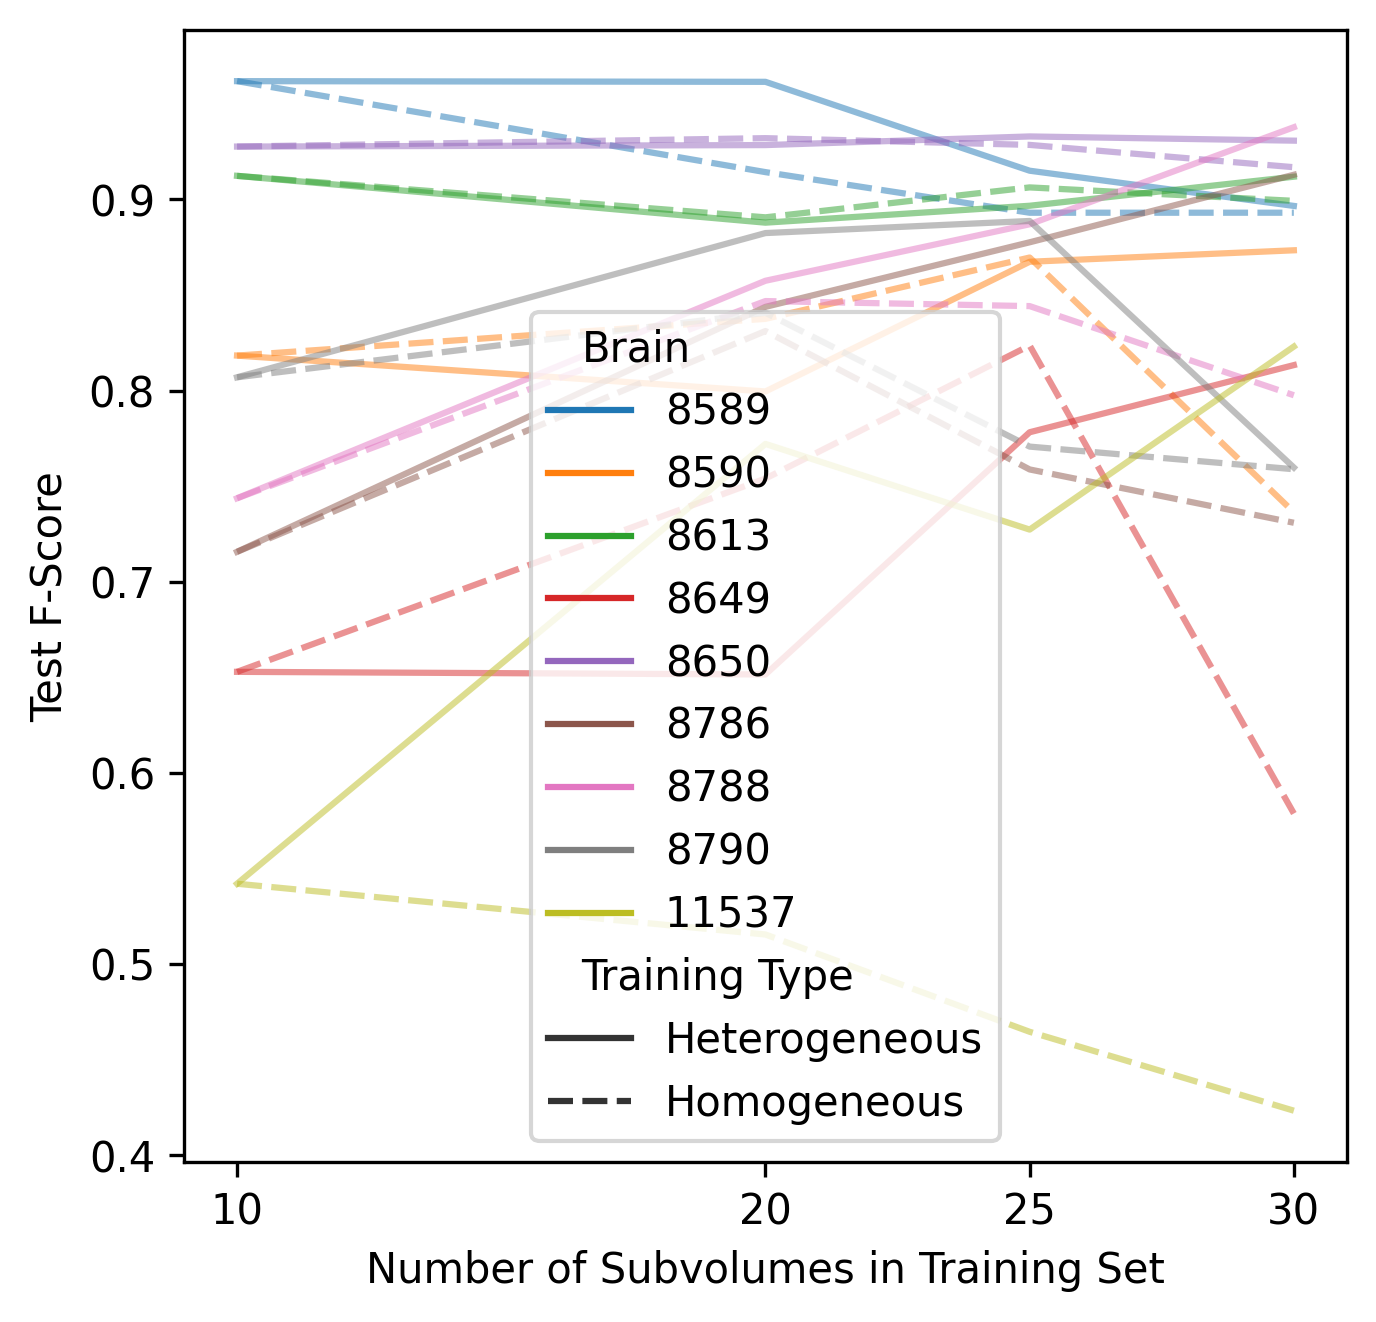

In [6]:
df = pd.DataFrame(
    data={
        "Test F-Score": fscores,
        "Number of Subvolumes in Training Set": train_sizes,
        "Brain": brains,
        "Training Type": model_lines,
    }
)
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
sns.lineplot(
    data=df,
    x="Number of Subvolumes in Training Set",
    y="Test F-Score",
    hue="Brain",
    style="Training Type",
    ax=axes,
    alpha=0.5,
    linestyle="dashed",
    palette="tab10",
)


# axes.plot(np.arange(len(models)), av_fscores, color='red', label="Average")
# leg = axes.legend(loc='lower right')
# leg_lines = leg.get_lines()
# for i in range(len(brain_order)):
#     leg_lines[i].set_linestyle("--")
axes.set_xticks(training_set_sizes)

[
    <matplotlib.axis.XTick object at 0x15fb11970>,
    <matplotlib.axis.XTick object at 0x15fb11940>,
    <matplotlib.axis.XTick object at 0x15fb35c10>,
    <matplotlib.axis.XTick object at 0x15fb4e250>
]

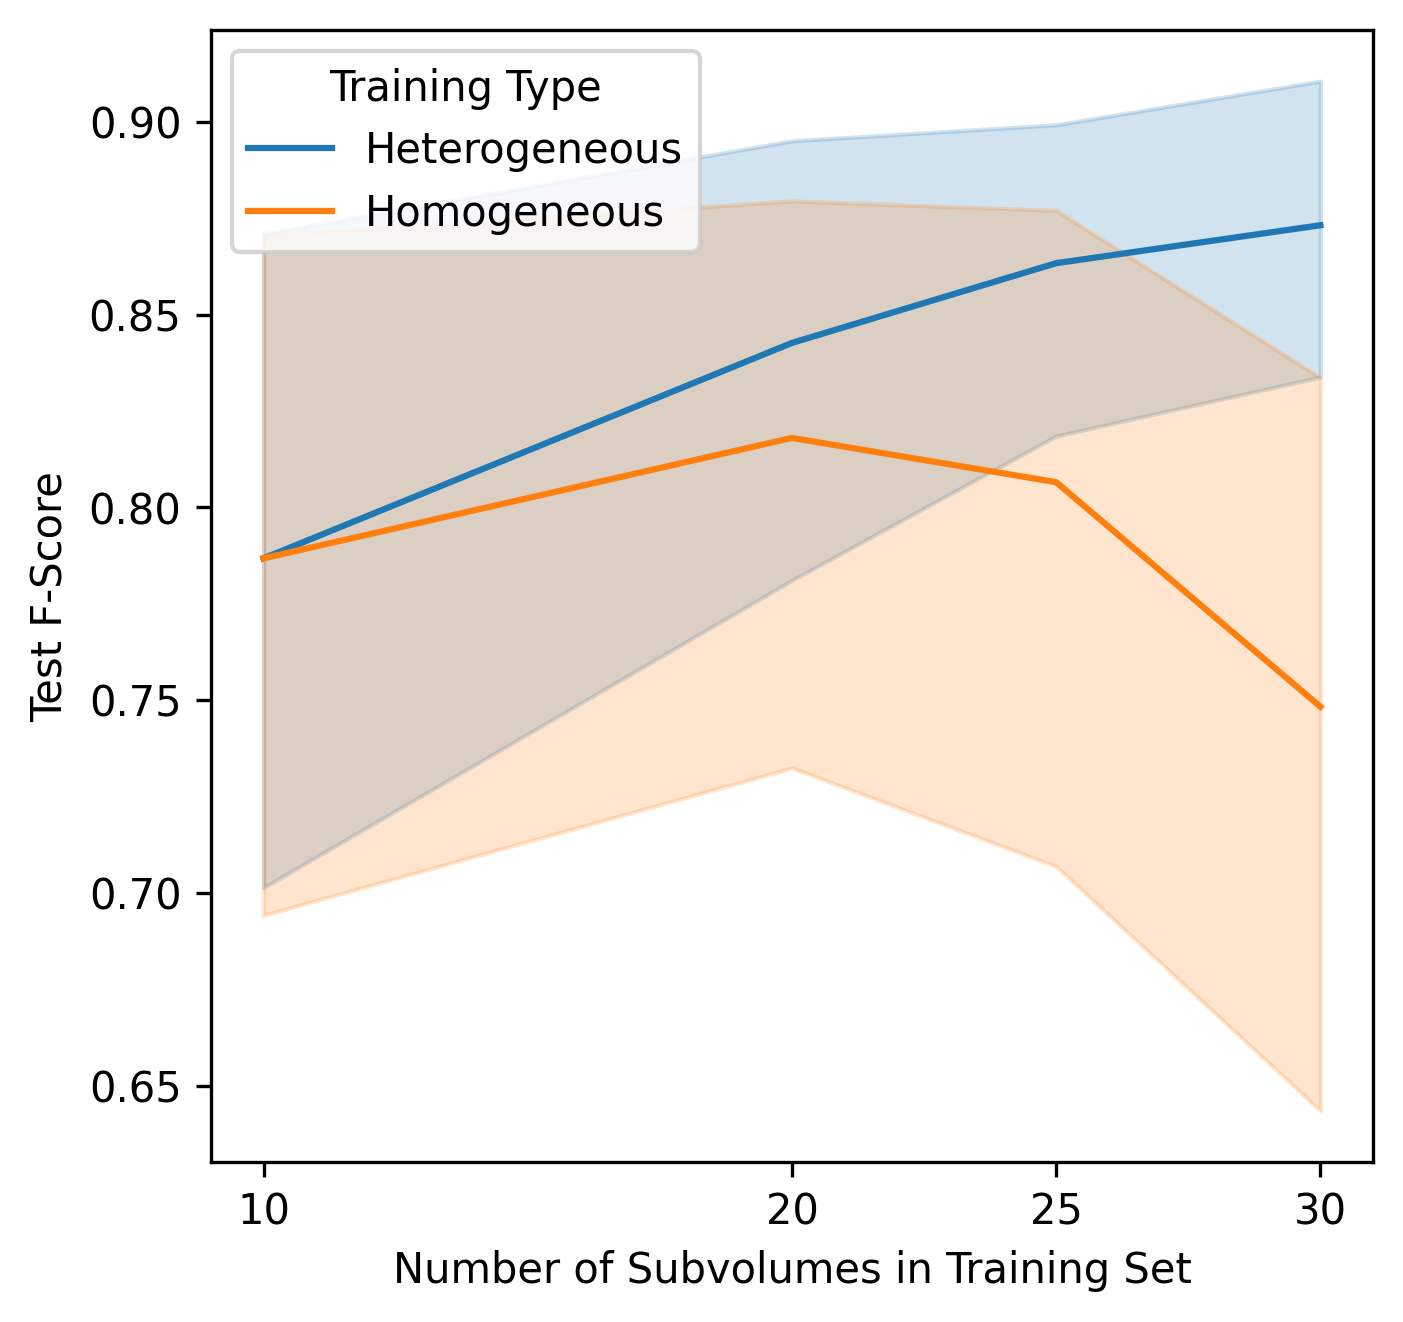

In [7]:
df = pd.DataFrame(
    data={
        "Test F-Score": fscores,
        "Number of Subvolumes in Training Set": train_sizes,
        "Brain": brains,
        "Training Type": model_lines,
    }
)
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
sns.lineplot(
    data=df,
    x="Number of Subvolumes in Training Set",
    y="Test F-Score",
    hue="Training Type",
)
axes.set_xticks(training_set_sizes)

# Soma

## Intensity data

In [8]:
data = {
    "8606": ([1726, 2619, 1687], [3071, 4360, 1687]),
    "8446": ([1979, 3491, 1791], [1258, 3502, 1791]),
    "887": ([3537, 3787, 1385], [2088, 1924, 1385]),
}  # soma center then nonsoma center

intensities = []
brain_ids = []
vol_type = []

for i, brain in enumerate(data.keys()):
    vol = CloudVolume(brain2paths_soma[brain]["base"] + "Ch_647")
    coord = data[brain][0]
    subvol = np.array(
        vol[
            coord[0] - 9 : coord[0] + 10,
            coord[1] - 9 : coord[1] + 10,
            coord[2] - 9 : coord[2] + 10,
        ],
        dtype="float",
    )
    num_entries = len(subvol.flatten())
    intensities += list(subvol.flatten())
    brain_ids += [i] * num_entries
    vol_type += ["Soma"] * num_entries

    coord = data[brain][1]
    subvol = np.array(
        vol[
            coord[0] - 9 : coord[0] + 10,
            coord[1] - 9 : coord[1] + 10,
            coord[2] - 9 : coord[2] + 10,
        ],
        dtype="float",
    )
    num_entries = len(subvol.flatten())
    intensities += list(subvol.flatten())
    brain_ids += [i] * num_entries
    vol_type += ["Background"] * num_entries

df = pd.DataFrame(
    data={"Intensity": intensities, "Subvolume Type": vol_type, "Sample": brain_ids}
)

Downloading: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s]


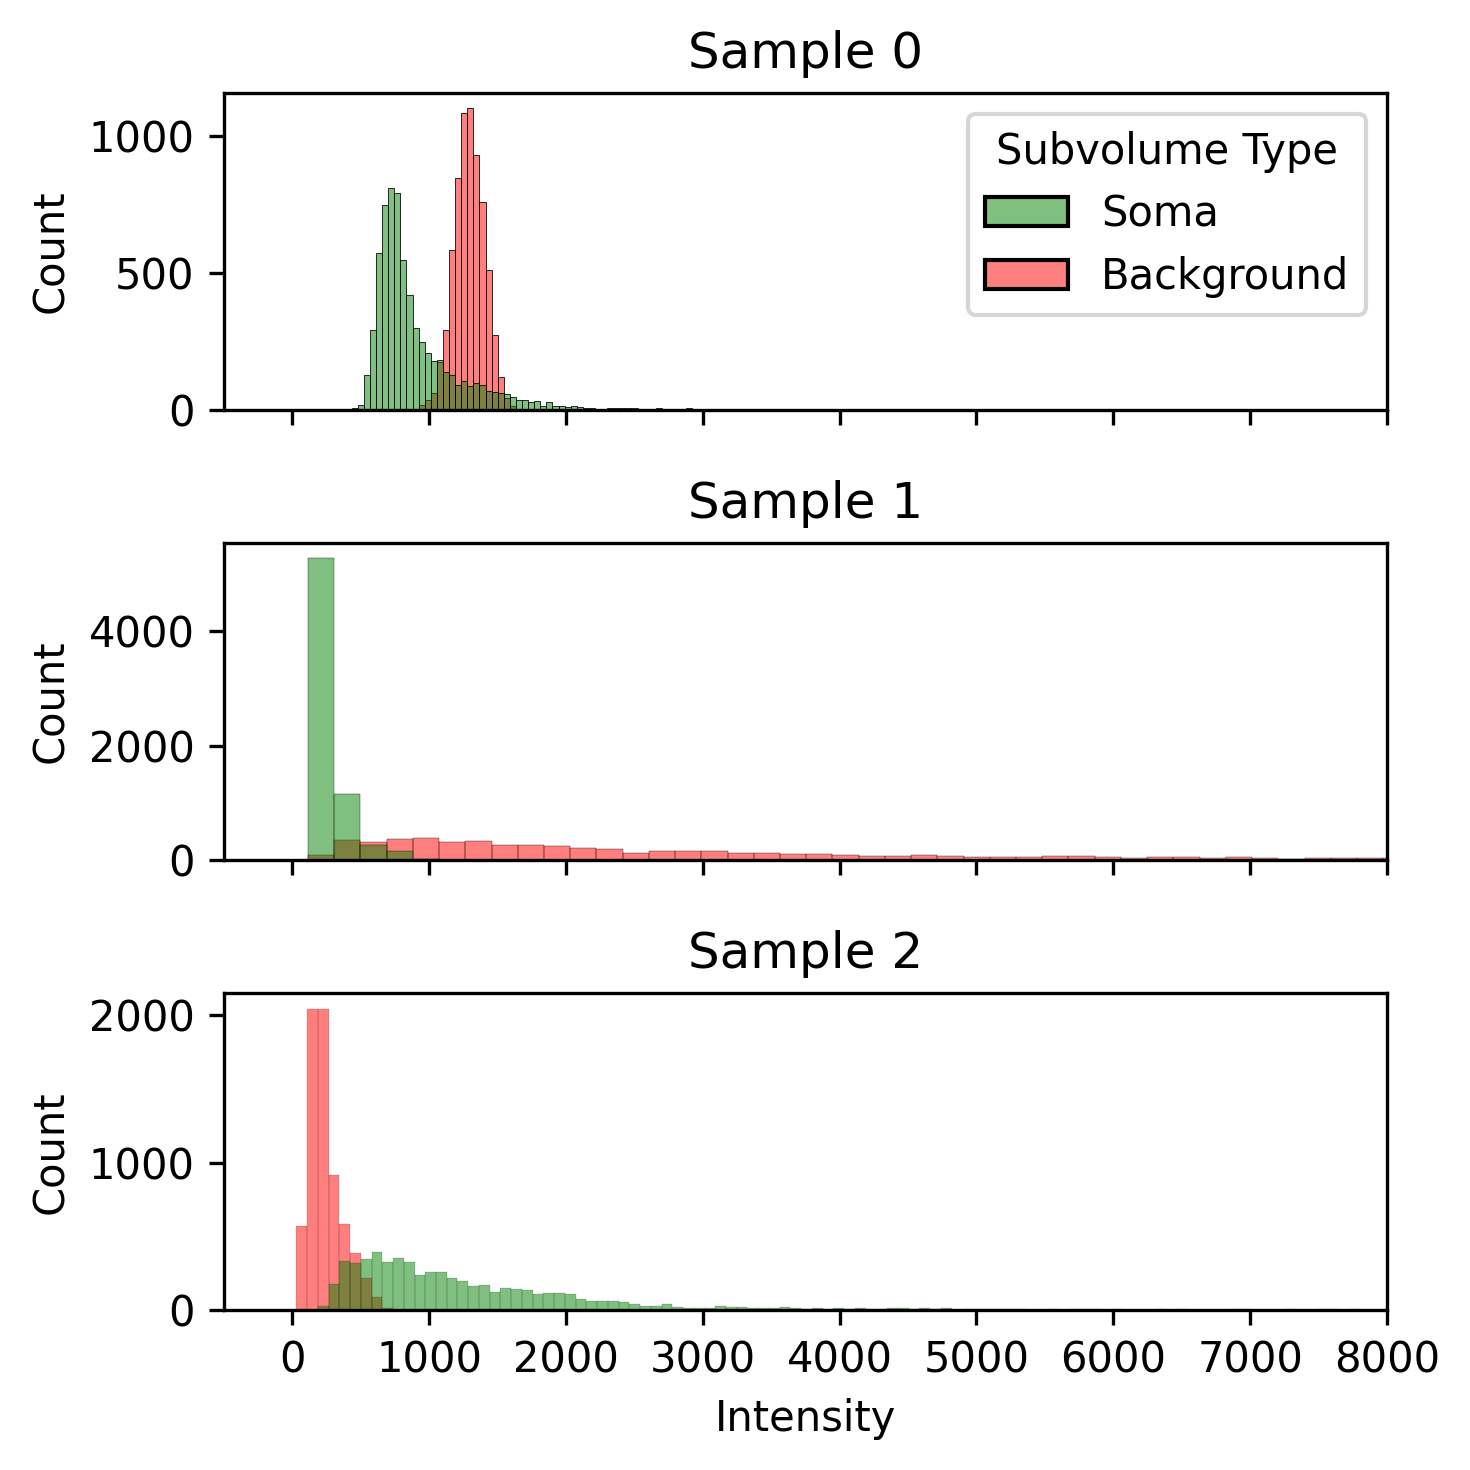

In [9]:
fig, axs = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(5, 5))
for i in range(3):
    hist = sns.histplot(
        data=df[df["Sample"] == i],
        x="Intensity",
        hue="Subvolume Type",
        ax=axs[i],
        palette=["green", "red"],
    )
    axs[i].set_title(f"Sample {i}")
    if i > 0:
        hist.get_legend().remove()

axs[0].set_xlim(-500, 8000)
plt.tight_layout()

## Compare to sample number

In [10]:
# training set results
training_brain_order = ["r1", "r2", "878", "887"]
models_diff = []
models_same = []

for i, brain in enumerate(training_brain_order):
    model_diff = "-compare"
    for j, brain2 in enumerate(training_brain_order[: i + 1]):
        model_diff += "-"
        model_diff += str(brain2)

        model_same = "-compare-r1"
        if j > 0:
            model_same += f"_{j+1}"

    models_diff.append(model_diff)
    models_same.append(model_same)

print(f"heterogeneous: {models_diff} homogeneous: {models_same}")

heterogeneous: ['-compare-r1', '-compare-r1-r2', '-compare-r1-r2-878', '-compare-r1-r2-878-887'] homogeneous: ['-compare-r1', '-compare-r1_2', '-compare-r1_3', '-compare-r1_4']


In [11]:
doubles = [
    "3972_1636_1575_pos_Probabilities.h5",
    "2867_4336_1296_pos_Probabilities.h5",
    "2607_1845_1309_pos_Probabilities.h5",
    "2101_3397_1747_pos_Probabilities.h5",
    "2011_3452_1911_pos_Probabilities.h5",
    "2113_3353_1727_pos_Probabilities.h5",
    "1968_3472_1784_pos_Probabilities.h5",
]  # 8446

In [13]:
brain_order = [
    "8607",
    "8606",
    "8477",
    "8531",
    "8608",
    "8529",
    "8557",
    "8555",
    "8446",
    "8454",
    "887",
]
training_set_sizes = [25, 45, 51, 59]
train_sizes = []
model_lines = []
fscores = []
brains = []
size_thresh = 500

for brain in tqdm(brain_order, desc="Evaluating brains..."):
    if brain == "8557":
        brain_name = "r1"
    elif brain == "8555":
        brain_name = "r2"
    else:
        brain_name = brain

    brain_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brain{brain_name}/val/"
    # identify images an split into val and test
    files = find_sample_names(brain_dir, dset="", add_dir=False)
    random.shuffle(files)
    half = int(len(files) / 2)
    val_files = files[:half]
    test_files = files[half:]

    for model_line, models in zip(
        ["Heterogeneous", "Homogeneous"], [models_diff, models_same]
    ):
        for model, train_size in zip(models, training_set_sizes):
            results_dir = brain_dir + "results" + model + "/"

            # val - choose best threshold
            pred_files = []
            for val_file in val_files:
                pred_file = f"{results_dir}{val_file.split('.')[0]}_Probabilities.h5"
                pred_files.append(pred_file)

            spacing = 0.02
            thresholds = np.arange(spacing, 1.0, spacing)
            best_fscore = 0
            best_thresh = -1

            for threshold in thresholds:
                tot_pos = 0
                true_pos = 0
                false_pos = 0

                for pred_file in pred_files:
                    if pred_file in doubles:
                        newpos = 2
                    else:
                        newpos = 1

                    f = h5py.File(pred_file, "r")
                    seg = f.get("exported_data")
                    seg = seg[0, :, :, :]
                    mask = seg > threshold
                    labels = measure.label(mask)
                    props = measure.regionprops(labels)

                    if "pos" in pred_file:
                        num_detected = 0
                        tot_pos += newpos
                        for prop in props:
                            if prop["area"] > size_thresh:
                                if num_detected < newpos:
                                    true_pos += 1
                                    num_detected += 1
                                else:
                                    false_pos += 1
                    elif "neg" in pred_file:
                        for prop in props:
                            if prop["area"] > size_thresh:
                                false_pos += 1
                if tot_pos == 0:
                    recall = 1
                else:
                    recall = true_pos / tot_pos

                if true_pos + false_pos == 0:
                    precision = 0
                else:
                    precision = true_pos / (true_pos + false_pos)

                if precision == 0 and recall == 0:
                    fscore = 0
                else:
                    fscore = 2 / (1 / precision + 1 / recall)

                if fscore > best_fscore:
                    best_fscore = fscore
                    best_thresh = threshold

            # test
            pred_files = []
            for val_file in test_files:
                pred_file = f"{results_dir}/{val_file.split('.')[0]}_Probabilities.h5"
                pred_files.append(pred_file)

            tot_pos = 0
            true_pos = 0
            false_pos = 0

            for pred_file in pred_files:
                if pred_file in doubles:
                    newpos = 2
                else:
                    newpos = 1

                f = h5py.File(pred_file, "r")
                seg = f.get("exported_data")
                seg = seg[0, :, :, :]
                mask = seg > best_thresh
                labels = measure.label(mask)
                props = measure.regionprops(labels)

                if "pos" in pred_file:
                    num_detected = 0
                    tot_pos += newpos
                    for prop in props:
                        if prop["area"] > size_thresh:
                            if num_detected < newpos:
                                true_pos += 1
                                num_detected += 1
                            else:
                                false_pos += 1
                elif "neg" in pred_file:
                    for prop in props:
                        if prop["area"] > size_thresh:
                            false_pos += 1

            if tot_pos == 0:
                recall = 1
            else:
                recall = true_pos / tot_pos

            if true_pos + false_pos == 0:
                precision = 0
            else:
                precision = true_pos / (true_pos + false_pos)

            if precision == 0 and recall == 0:
                fscore = 0
            else:
                fscore = 2 / (1 / precision + 1 / recall)

            fscores.append(fscore)
            train_sizes.append(train_size)
            brains.append(brain)

            model_lines.append(model_line)

Evaluating brains...: 100%|██████████| 11/11 [03:22<00:00, 18.43s/it]


[
    <matplotlib.axis.XTick object at 0x160d2b070>,
    <matplotlib.axis.XTick object at 0x160d2b0a0>,
    <matplotlib.axis.XTick object at 0x160d419d0>,
    <matplotlib.axis.XTick object at 0x160d92940>
]

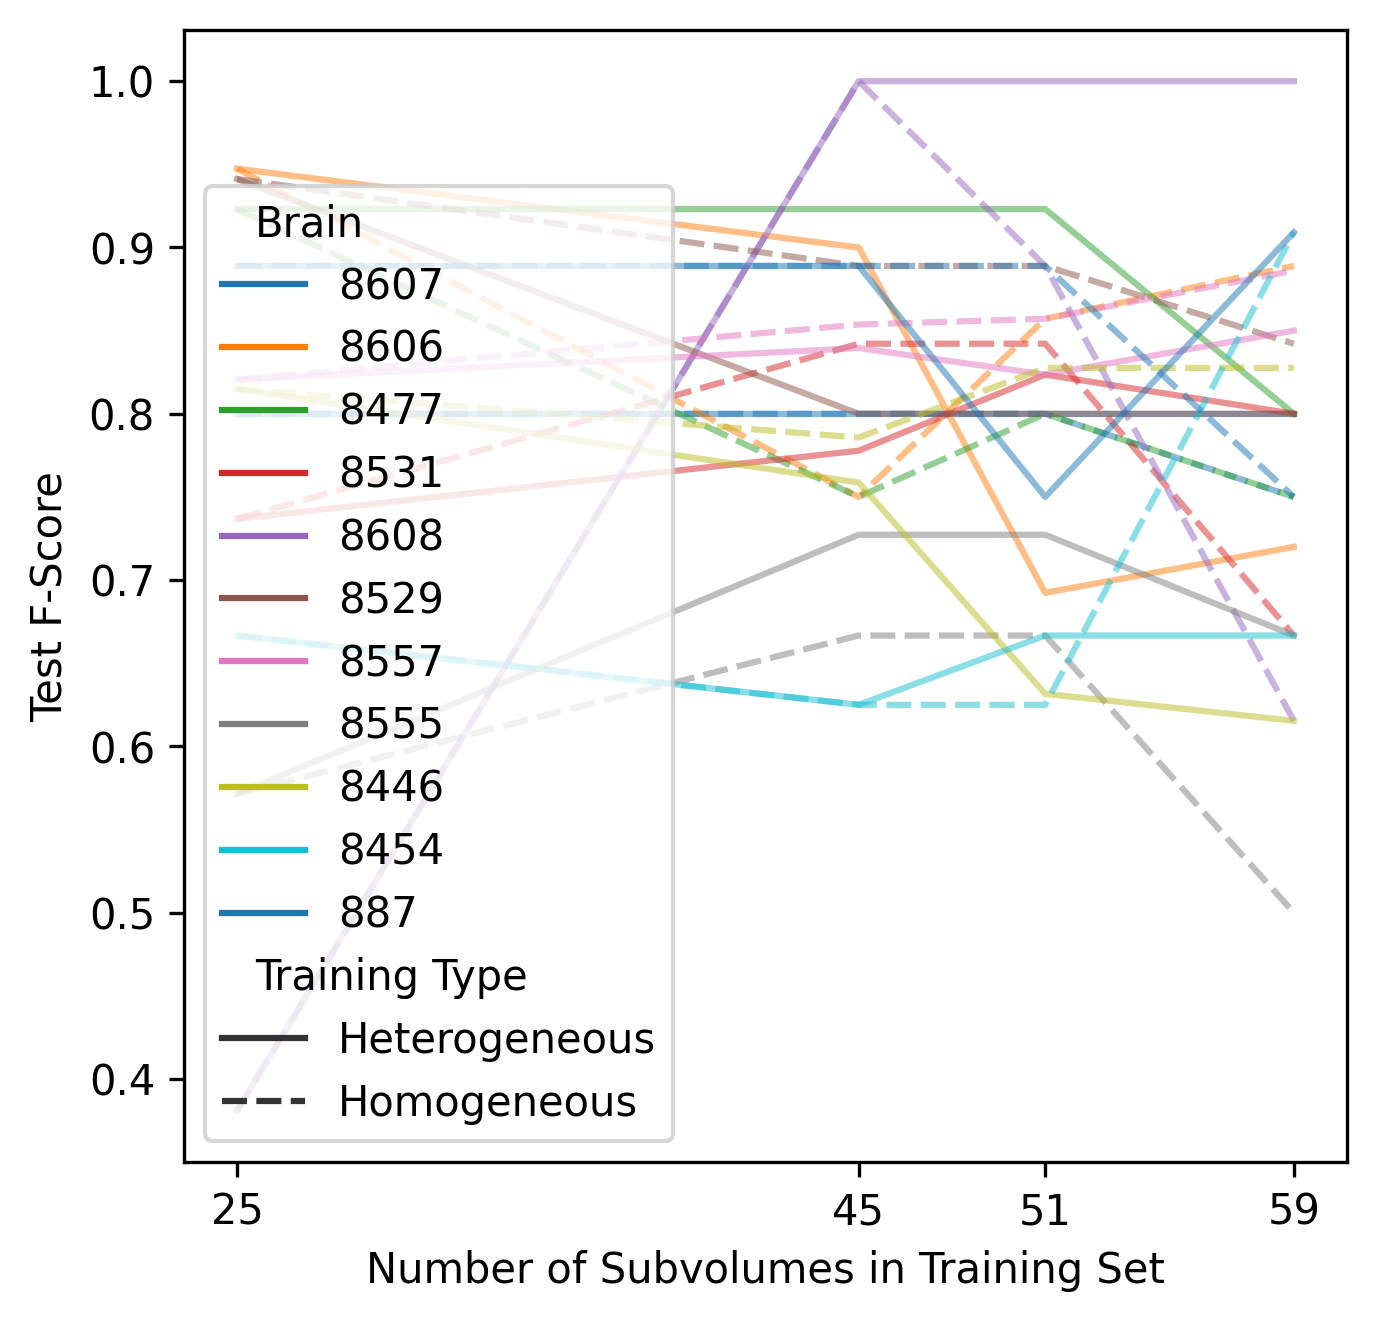

In [14]:
df = pd.DataFrame(
    data={
        "Test F-Score": fscores,
        "Number of Subvolumes in Training Set": train_sizes,
        "Brain": brains,
        "Training Type": model_lines,
    }
)
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
sns.lineplot(
    data=df,
    x="Number of Subvolumes in Training Set",
    y="Test F-Score",
    hue="Brain",
    style="Training Type",
    ax=axes,
    alpha=0.5,
    linestyle="dashed",
    palette="tab10",
)


# axes.plot(np.arange(len(models)), av_fscores, color='red', label="Average")
# leg = axes.legend(loc='lower right')
# leg_lines = leg.get_lines()
# for i in range(len(brain_order)):
#     leg_lines[i].set_linestyle("--")
axes.set_xticks(training_set_sizes)

[
    <matplotlib.axis.XTick object at 0x160e44310>,
    <matplotlib.axis.XTick object at 0x160e442e0>,
    <matplotlib.axis.XTick object at 0x160e5f5b0>,
    <matplotlib.axis.XTick object at 0x160e850d0>
]

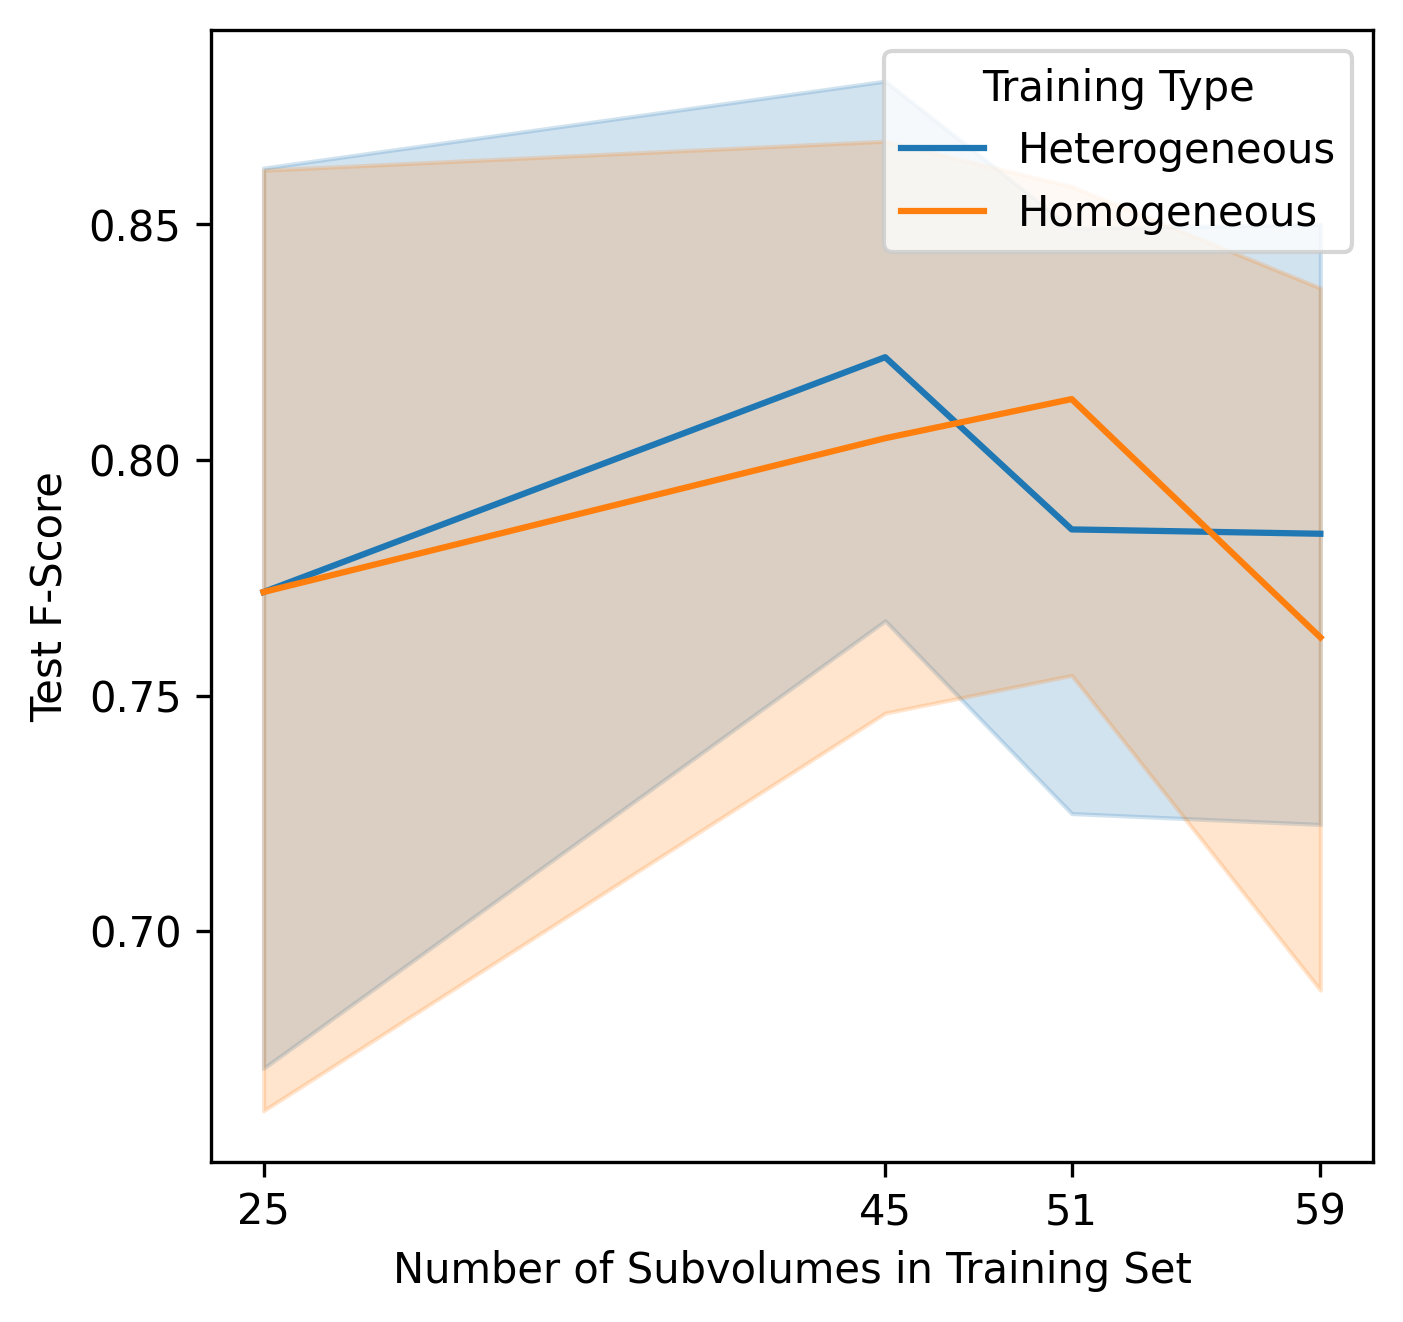

In [15]:
df = pd.DataFrame(
    data={
        "Test F-Score": fscores,
        "Number of Subvolumes in Training Set": train_sizes,
        "Brain": brains,
        "Training Type": model_lines,
    }
)
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
sns.lineplot(
    data=df,
    x="Number of Subvolumes in Training Set",
    y="Test F-Score",
    hue="Training Type",
)
axes.set_xticks(training_set_sizes)

# Old

## Axon Accuracy Plots

In [4]:
# training set results
training_brain_order = [3, 4, 8649, 8788]
models = []
for i, brain in enumerate(training_brain_order):
    model = ""
    for j, brain2 in enumerate(training_brain_order[: i + 1]):
        model += "-"
        model += str(brain2)
    models.append(model)

sample_ids = {8589: 3, 8590: 4, 8613: 5, 8649: 6, 8650: 7, 8788: 8}

### Plot best f scores

Inventory:
Brains 8589, 8590, 8613, 8649, 8650
models: All single ones, then sequential 8649, 8650, 8589, 8613, 8590
Results: all single ones

Plot idea: Total accuracy over time: need all models to be evaluated on all datasets

In [5]:
brain_order = [8650, 8649, 8613, 8589, 8590, 8788]
models_results = []
fscores = []
brains = []
av_fscores = []

for model_n, model in enumerate(tqdm(models, desc="Cycling through models...")):
    av_fscore = []
    for brain in tqdm(brain_order, desc="Evaluating brains..."):
        brain_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain{brain}/"
        results_dir = brain_dir + "results" + model

        # identify images an split into val and test
        files = find_sample_names(brain_dir, dset="val", add_dir=False)
        random.shuffle(files)
        half = int(len(files) / 2)
        val_files = files[:half]
        test_files = files[half:]

        # val - choose best threshold
        true_files = []
        pred_files = []
        for val_file in val_files:
            true_file = f"{brain_dir}/{val_file.split('.')[0]}-image_2channel_Labels.h5"
            true_files.append(true_file)
            pred_file = f"{results_dir}/{val_file.split('.')[0]}_Probabilities.h5"
            pred_files.append(pred_file)

        spacing = 0.02
        thresholds = np.arange(spacing, 1.0, spacing)
        best_fscore = 0
        best_thresh = -1

        for threshold in tqdm(thresholds, desc="searching threshold...", leave=False):
            true_pos_total = 0
            false_pos_total = 0
            true_labels_total = 0

            for true_file, pred_file in zip(true_files, pred_files):
                f = h5py.File(pred_file, "r")
                seg = f.get("exported_data")
                seg = seg[1, :, :, :]
                mask_forward = seg > threshold

                f = h5py.File(true_file, "r")
                gt = f.get("exported_data")
                gt = gt[0, :, :, :]
                pos_labels = gt == 2
                neg_labels = gt == 1

                true_pos = np.sum(np.logical_and(mask_forward, pos_labels))
                true_pos_total += true_pos

                false_pos = np.sum(np.logical_and(mask_forward, gt == 1))
                false_pos_total += false_pos

                true_labels = np.sum(pos_labels)
                true_labels_total += true_labels

            precision_total = true_pos_total / (true_pos_total + false_pos_total)
            recall_total = true_pos_total / true_labels_total
            fscore = 2 / (1 / precision_total + 1 / recall_total)

            if fscore > best_fscore:
                best_fscore = fscore
                best_thresh = threshold

        # test
        true_files = []
        pred_files = []
        for val_file in test_files:
            true_file = f"{brain_dir}/{val_file.split('.')[0]}-image_2channel_Labels.h5"
            true_files.append(true_file)
            pred_file = f"{results_dir}/{val_file.split('.')[0]}_Probabilities.h5"
            pred_files.append(pred_file)

        true_pos_total = 0
        false_pos_total = 0
        true_labels_total = 0

        for true_file, pred_file in zip(true_files, pred_files):
            f = h5py.File(pred_file, "r")
            seg = f.get("exported_data")
            seg = seg[1, :, :, :]
            mask_forward = seg > best_thresh

            f = h5py.File(true_file, "r")
            gt = f.get("exported_data")
            gt = gt[0, :, :, :]
            pos_labels = gt == 2
            neg_labels = gt == 1

            true_pos = np.sum(np.logical_and(mask_forward, pos_labels))
            true_pos_total += true_pos

            false_pos = np.sum(np.logical_and(mask_forward, gt == 1))
            false_pos_total += false_pos

            true_labels = np.sum(pos_labels)
            true_labels_total += true_labels

        precision_total = true_pos_total / (true_pos_total + false_pos_total)
        recall_total = true_pos_total / true_labels_total
        fscore = 2 / (1 / precision_total + 1 / recall_total)

        fscores.append(fscore)
        models_results.append(model_n)
        brains.append(sample_ids[brain])

        av_fscore.append(fscore)

    av_fscores.append(np.mean(av_fscore))

Cycling through models...:   0%|          | 0/4 [00:00<?, ?it/s]



















Cycling through models...:   0%|          | 0/4 [00:02<?, ?it/s]


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain8649/results-3/val_3908_3033_957_Probabilities.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
df = pd.DataFrame(
    data={"Test F-Score": fscores, "Training Dataset": models_results, "Brain": brains}
)
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
sns.lineplot(
    data=df,
    x="Training Dataset",
    y="Test F-Score",
    hue="Brain",
    ax=axes,
    alpha=0.5,
    linestyle="dashed",
    palette="tab10",
)

axes.plot(np.arange(len(models)), av_fscores, color="red", label="Average")
leg = axes.legend(loc="lower right")
leg_lines = leg.get_lines()
for i in range(len(brain_order)):
    leg_lines[i].set_linestyle("--")
axes.set_xticks(np.arange(len(models)))

## Soma test results

In [ ]:
# training set results
brain_order = ["r1", "r2", "878", "887"]
brains = [8607, 8606, 8477, 8531, 8608, 8529, 8557, 8555, 8446, 8454, 887]
models = []
for i, brain in enumerate(brain_order):
    model = "results"
    for j, brain2 in enumerate(brain_order[: i + 1]):
        if j > 0:
            model += "_"
        model += str(brain2)
    models.append(model)

print(models)

size_thresh = 500
doubles = [
    "3972_1636_1575_pos_Probabilities.h5",
    "2867_4336_1296_pos_Probabilities.h5",
    "2607_1845_1309_pos_Probabilities.h5",
    "2101_3397_1747_pos_Probabilities.h5",
    "2011_3452_1911_pos_Probabilities.h5",
    "2113_3353_1727_pos_Probabilities.h5",
    "1968_3472_1784_pos_Probabilities.h5",
]  # 8446


sample_ids = {b: i + 2 for i, b in enumerate(np.sort(brains))}
print(f"sample ids: {sample_ids}")

In [ ]:
models_results = []
fscores = []
brains_results = []
av_fscores = []

for model_n, model in enumerate(tqdm(models, desc="Cycling through models...")):
    av_fscore = []
    for brain in tqdm(brains, desc="Evaluating brains..."):
        if brain == 8557:
            brain_name = "r1"
        elif brain == 8555:
            brain_name = "r2"
        else:
            brain_name = brain

        images_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brain{brain_name}/3channel/test/images_only/"
        results_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brain{brain_name}/3channel/test/{model}/"
        files = find_sample_names(images_dir, dset="", add_dir=False)
        files = [r[:-3] + "_Probabilities.h5" for r in files]

        reshuffle = True
        while reshuffle:
            random.shuffle(files)
            half = int(len(files) / 2)
            val_files = files[:half]
            test_files = files[half:]
            for val_file in val_files:
                if "pos" in val_file:
                    for test_file in test_files:
                        if "pos" in test_file:
                            reshuffle = False
                            break

                    break

        # Baseline
        spacing = 0.02
        thresholds = np.arange(spacing, 1.0, spacing)
        best_fscore = 0
        best_thresh = -1

        for threshold in tqdm(
            thresholds, desc="searching threshold...", leave=False, disable=True
        ):
            tot_pos = 0
            true_pos = 0
            false_pos = 0

            for results_file in val_files:
                if results_file in doubles:
                    newpos = 2
                else:
                    newpos = 1

                f = h5py.File(results_dir + results_file, "r")
                seg = f.get("exported_data")
                seg = seg[0, :, :, :]
                mask = seg > threshold
                labels = measure.label(mask)
                props = measure.regionprops(labels)

                if "pos" in results_file:
                    num_detected = 0
                    tot_pos += newpos
                    for prop in props:
                        if prop["area"] > size_thresh:
                            if num_detected < newpos:
                                true_pos += 1
                                num_detected += 1
                            else:
                                false_pos += 1
                elif "neg" in results_file:
                    for prop in props:
                        if prop["area"] > size_thresh:
                            false_pos += 1

            recall = true_pos / tot_pos
            if true_pos + false_pos == 0:
                precision = 0
            else:
                precision = true_pos / (true_pos + false_pos)

            if precision == 0 and recall == 0:
                fscore = 0
            else:
                fscore = 2 * precision * recall / (precision + recall)

            if fscore > best_fscore:
                best_fscore = fscore
                best_thresh = threshold

        true_pos = 0
        false_pos = 0
        tot_pos = 0

        for results_file in test_files:
            if results_file in doubles:
                newpos = 2
            else:
                newpos = 1

            f = h5py.File(results_dir + results_file, "r")
            seg = f.get("exported_data")
            seg = seg[0, :, :, :]
            mask = seg > best_thresh
            labels = measure.label(mask)
            props = measure.regionprops(labels)

            if "pos" in results_file:
                num_detected = 0
                tot_pos += newpos
                for prop in props:
                    if prop["area"] > size_thresh:
                        if num_detected < newpos:
                            true_pos += 1
                            num_detected += 1
                        else:
                            false_pos += 1
            elif "neg" in results_file:
                for prop in props:
                    if prop["area"] > size_thresh:
                        false_pos += 1

        recall = true_pos / tot_pos
        if true_pos + false_pos == 0:
            precision = 0
        else:
            precision = true_pos / (true_pos + false_pos)

        if precision == 0 and recall == 0:
            fscore = 0
        else:
            fscore = 2 * precision * recall / (precision + recall)

        av_fscore.append(fscore)
        fscores.append(fscore)
        models_results.append(model_n)
        brains_results.append(sample_ids[brain])

    av_fscores.append(np.mean(av_fscore))

In [ ]:
df = pd.DataFrame(
    data={
        "Test F-Score": fscores,
        "Training Dataset": models_results,
        "Brain": brains_results,
    }
)
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)

sns.lineplot(
    data=df,
    x="Training Dataset",
    y="Test F-Score",
    hue="Brain",
    ax=ax,
    linestyle="dashed",
    alpha=0.5,
    palette="tab10",
)
ax.plot(np.arange(len(models)), av_fscores, color="red", label="Average")
leg = ax.legend(loc="lower right")
leg_lines = leg.get_lines()
for i in range(len(brains)):
    leg_lines[i].set_linestyle("--")

ax.set_xticks(np.arange(len(models)))